In [1]:
#!pip install prophet pandas scikit-learn matplotlib tqdm --quiet

# Predicción de Regalías con Prophet Multivariado
### Tesis de Maestría en Ciencia de Datos
Este notebook utiliza Facebook Prophet con regresores externos para predecir regalías mensuales por artista.
Se evalúan métricas por artista y se exportan resultados para Power BI.

In [2]:
import pandas as pd

#file_id = '14dqOhZOxoLZVI0vtsf03g_VSJsm05Me_' #version 1
file_id = '19rKtmLEbIyBd0b5HUxBzXxJb92YegK8W' #version 2
url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(url)
df['fecha'] = pd.to_datetime(df['fecha'], format='%m/%d/%Y')
df.head()

,songstats_artist_id,fecha,royalties,instagram_followers,twitter_followers,track_release,sentiment,seguidores_menciones,cant_posteos,cant_comentarios,mean_royalties_6m,std_instagram_followers_6m,growth_twitter_followers,growth_instagram_followers,sum_track_releases_6m,mean_sentiment_3m,sum_seguidores_menciones_3m,month
0,436lvfnz,2022-07-01,94291.905,5250688,643908,1,0.649123,26326461,3,57,94291.90500,0.00000,0,0,1,0.649123,26326461,7
1,436lvfnz,2022-08-01,90967.300,5283706,647332,0,0.493088,26326461,7,217,92629.60250,23347.25170,3424,33018,1,0.571105,52652922,8
2,436lvfnz,2022-09-01,96849.325,5316966,648728,1,0.703297,0,5,91,94036.17667,33139.07363,1396,33260,2,0.615169,52652922,9
3,436lvfnz,2022-10-01,94944.180,5346661,649390,0,0.548611,50734,5,144,94263.17750,41478.03735,662,29695,2,0.581665,26377195,10
4,436lvfnz,2022-11-01,93308.900,5403544,649732,1,0.557554,26326461,10,278,94072.32200,58780.37927,342,56883,3,0.603154,26377195,11


In [3]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from tqdm.notebook import tqdm

resultados = []
predicciones = []

for artist_id, group in tqdm(df.groupby("songstats_artist_id")):
    group = group.sort_values("fecha")
    if len(group) < 10:
        continue

    # Renombrar columnas para Prophet
    df_prophet = pd.DataFrame({
        'ds': group['fecha'],
        'y': group['royalties'],
        'instagram_followers': group['instagram_followers'],
        'twitter_followers': group['twitter_followers'],
        'track_release': group['track_release'],
        'sentiment': group['sentiment'],
        'seguidores_menciones': group['seguidores_menciones'],
        'cant_posteos': group['cant_posteos'],
        'cant_comentarios': group['cant_comentarios'],
        'mean_royalties_6m': group['mean_royalties_6m'],
        'std_instagram_followers_6m': group['std_instagram_followers_6m'],
        'growth_twitter_followers': group['growth_twitter_followers'],
        'growth_instagram_followers': group['growth_instagram_followers'],
        'sum_track_releases_6m': group['sum_track_releases_6m'],
        'mean_sentiment_3m': group['mean_sentiment_3m'],
        'sum_seguidores_menciones_3m': group['sum_seguidores_menciones_3m'],
        'month': group['month']
    })

    train_size = int(len(df_prophet) * 0.8)
    train = df_prophet.iloc[:train_size]
    test = df_prophet.iloc[train_size:]

    try:
        model = Prophet()
        model.add_regressor('instagram_followers')
        model.add_regressor('twitter_followers')
        model.add_regressor('track_release')
        model.add_regressor('sentiment')
        model.add_regressor('seguidores_menciones')
        model.add_regressor('cant_posteos')
        model.add_regressor('cant_comentarios')
        model.add_regressor('mean_royalties_6m')
        model.add_regressor('std_instagram_followers_6m')
        model.add_regressor('growth_twitter_followers')
        model.add_regressor('growth_instagram_followers')
        model.add_regressor('sum_track_releases_6m')
        model.add_regressor('mean_sentiment_3m')
        model.add_regressor('sum_seguidores_menciones_3m')
        model.add_regressor('month')

        model.fit(train)

        forecast = model.predict(test)

        mse = mean_squared_error(test['y'], forecast['yhat'])
        mae = mean_absolute_error(test['y'], forecast['yhat'])
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(test['y'], forecast['yhat'])

        resultados.append({
            'Artist_ID': artist_id,
            'Modelo': 'Prophet',
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        })

        for i in range(len(test)):
            predicciones.append({
                'songstats_artist_id': artist_id,
                'fecha': test.iloc[i]['ds'],
                'royalties_real': test.iloc[i]['y'],
                'royalties_pred': forecast.iloc[i]['yhat'],
                'modelo': 'Prophet'
            })

    except:
        continue

  0%|          | 0/15 [00:00<?, ?it/s]

16:43:15 - cmdstanpy - INFO - Chain [1] start processing
16:43:43 - cmdstanpy - INFO - Chain [1] done processing
16:43:43 - cmdstanpy - INFO - Chain [1] start processing
16:43:44 - cmdstanpy - INFO - Chain [1] done processing
16:43:44 - cmdstanpy - INFO - Chain [1] start processing
16:43:45 - cmdstanpy - INFO - Chain [1] done processing
16:43:45 - cmdstanpy - INFO - Chain [1] start processing
16:43:55 - cmdstanpy - INFO - Chain [1] done processing
16:43:56 - cmdstanpy - INFO - Chain [1] start processing
16:44:31 - cmdstanpy - INFO - Chain [1] done processing
16:44:32 - cmdstanpy - INFO - Chain [1] start processing
16:45:06 - cmdstanpy - INFO - Chain [1] done processing
16:45:06 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] done processing
16:45:40 - cmdstanpy - INFO - Chain [1] start processing
16:46:09 - cmdstanpy - INFO - Chain [1] done processing
16:46:10 - cmdstanpy - INFO - Chain [1] start processing
16:46:14 - cmdstanpy - INFO - Chain [1]

In [4]:
df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv("prophet_metrics_por_artista.csv", index=False)

df_predicciones = pd.DataFrame(predicciones)
df_predicciones.to_csv("prophet_predicciones_para_powerbi.csv", index=False)
df_resultados.head()

,Artist_ID,Modelo,MSE,MAE,RMSE,MAPE
0,436lvfnz,Prophet,2.329510e+10,1.272733e+05,1.526273e+05,0.783282
1,5jwhbt0o,Prophet,7.070968e+06,2.376569e+03,2.659129e+03,0.195634
2,5t4iv6o3,Prophet,1.461487e+10,1.132019e+05,1.208920e+05,0.339705
3,65m1vtnc,Prophet,2.194352e+12,1.237463e+06,1.481335e+06,1.813010
4,67gc5xm9,Prophet,5.365155e+10,1.956130e+05,2.316280e+05,0.516312


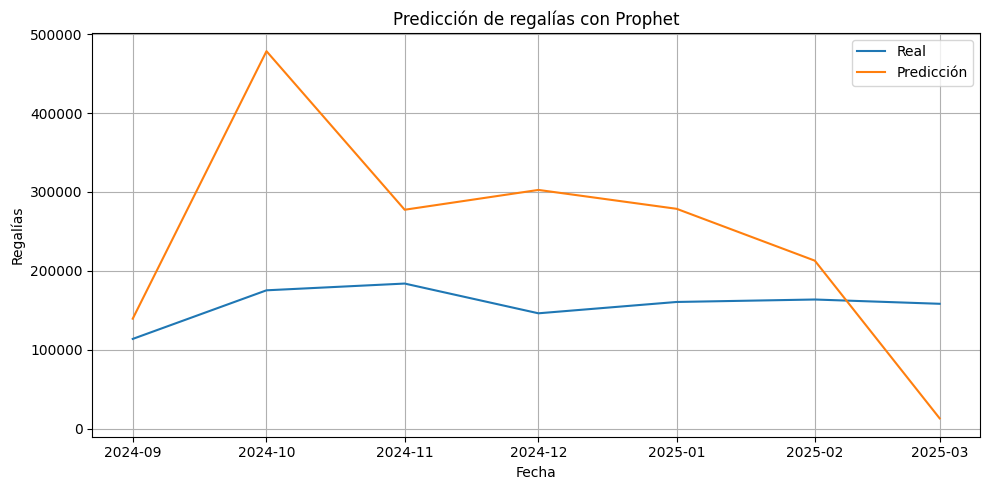

In [5]:
import matplotlib.pyplot as plt

ejemplo = df_predicciones[df_predicciones["songstats_artist_id"] == df_predicciones["songstats_artist_id"].unique()[0]]
plt.figure(figsize=(10,5))
plt.plot(ejemplo["fecha"], ejemplo["royalties_real"], label="Real")
plt.plot(ejemplo["fecha"], ejemplo["royalties_pred"], label="Predicción")
plt.title("Predicción de regalías con Prophet")
plt.xlabel("Fecha")
plt.ylabel("Regalías")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Forecast

In [6]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

def forecast_prophet_por_artista(df, artist_id, steps=6):
    """
    Entrena Prophet por artista y realiza forecast.

    Parámetros:
    - df: DataFrame
    - artist_id: ID del artista
    - steps: cantidad de meses a predecir

    Retorna:
    - forecast_df: DataFrame con predicciones
    - fig: gráfico
    """
    # Filtrar artista
    df_artista = df[df['songstats_artist_id'] == artist_id].copy()
    df_artista = df_artista.sort_values('fecha')

    # Validar datos suficientes
    if df_artista.empty or df_artista['royalties'].notna().sum() < 2:
        raise ValueError(f'El artista {artist_id} no tiene datos suficientes.')

    # Formatear para Prophet
    df_prophet = df_artista.rename(columns={'fecha': 'ds', 'royalties': 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

    # Entrenar modelo
    modelo = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    modelo.fit(df_prophet)

    # Crear fechas futuras
    future = modelo.make_future_dataframe(periods=steps, freq='MS')  # 'MS' = Month Start
    forecast = modelo.predict(future)

    # Tomar solo las fechas futuras
    forecast_future = forecast[forecast['ds'] > df_prophet['ds'].max()].copy()

    # DataFrame de predicción
    forecast_df = pd.DataFrame({
        'songstats_artist_id': artist_id,
        'fecha_prediccion': forecast_future['ds'],
        'royalties_forecast': forecast_future['yhat'],
        'lower_ci': forecast_future['yhat_lower'],
        'upper_ci': forecast_future['yhat_upper']
    })

    # Gráfico
    fig = modelo.plot(forecast)
    plt.title(f'Forecast Prophet - Artista {artist_id}')
    plt.xlabel('Fecha')
    plt.ylabel('Royalties')
    plt.tight_layout()
    plt.close(fig)

    return forecast_df, fig

# Lista de artistas
lista_artistas = df['songstats_artist_id'].unique()

# Almacenar resultados
lista_forecasts = []
lista_figuras = []

# Loop con try-except
for artist_id in lista_artistas:
    try:
        forecast_df, figura = forecast_prophet_por_artista(df, artist_id, steps=6)
        lista_forecasts.append(forecast_df)
        lista_figuras.append((artist_id, figura))
    except ValueError as e:
        print(f"Salteando artista {artist_id}: {e}")

# Consolidar todos los pronósticos en un único DataFrame
df_forecasts_consolidado = pd.concat(lista_forecasts, ignore_index=True)


16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\FlorenciaFederico\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\FlorenciaFederico\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
16:48:49 - cmdstanpy - INFO - Chain [1] start processing
16:48:50 - cmdstanpy - INFO -

Gráfico de forecast para el artista 436lvfnz


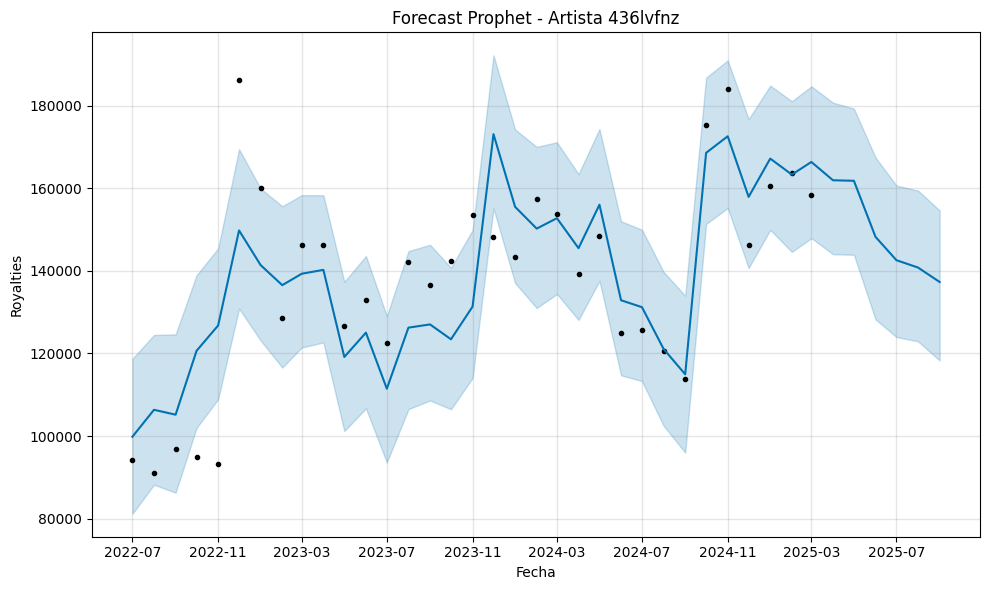

Gráfico de forecast para el artista 5jwhbt0o


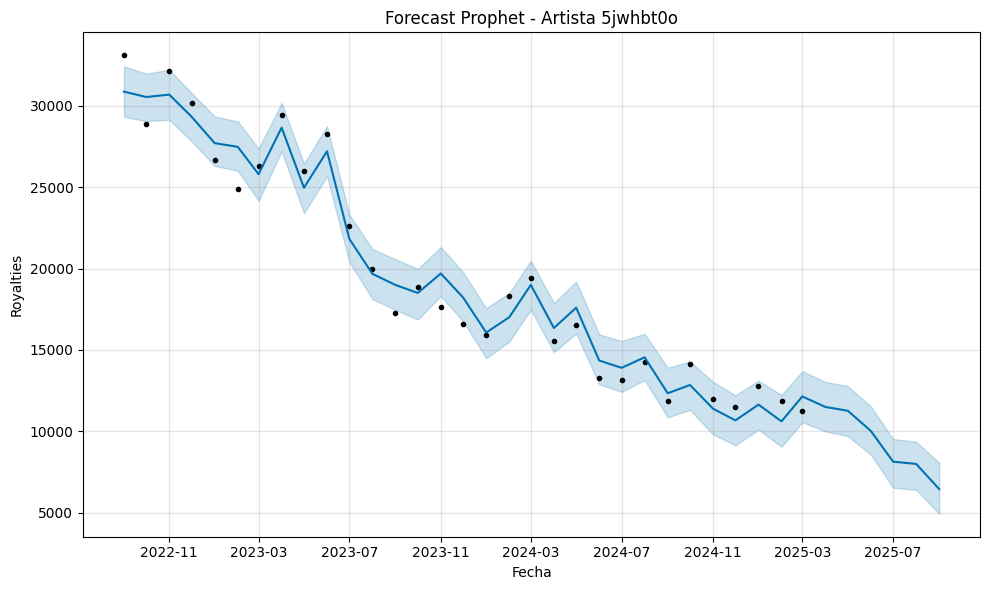

Gráfico de forecast para el artista 5t4iv6o3


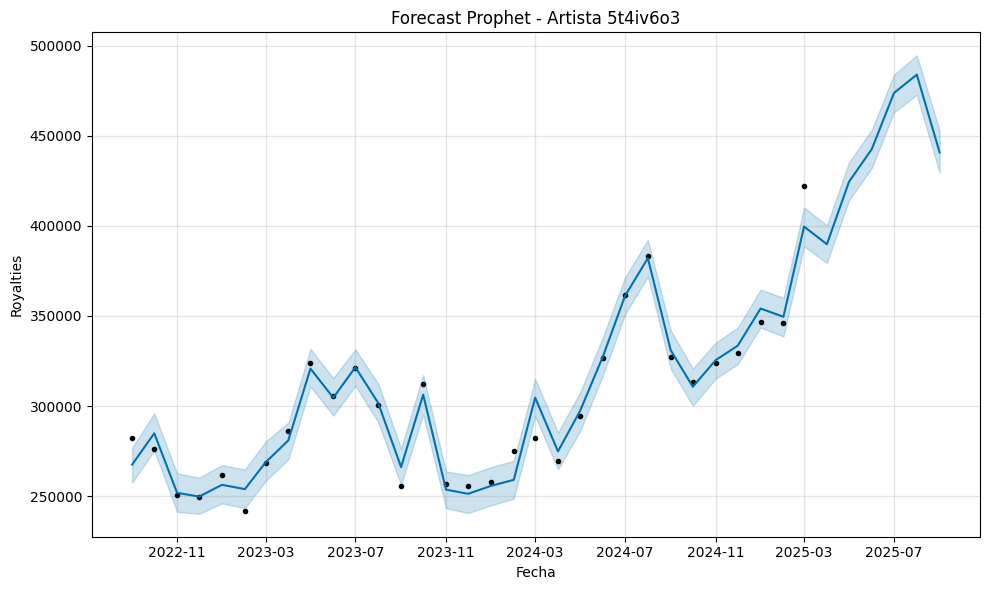

Gráfico de forecast para el artista 65m1vtnc


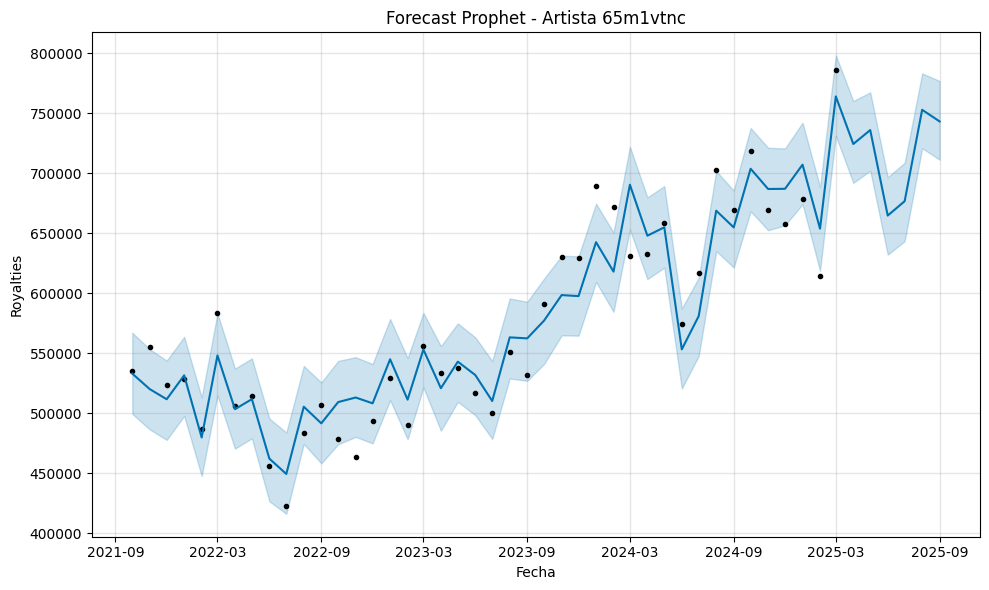

Gráfico de forecast para el artista 67gc5xm9


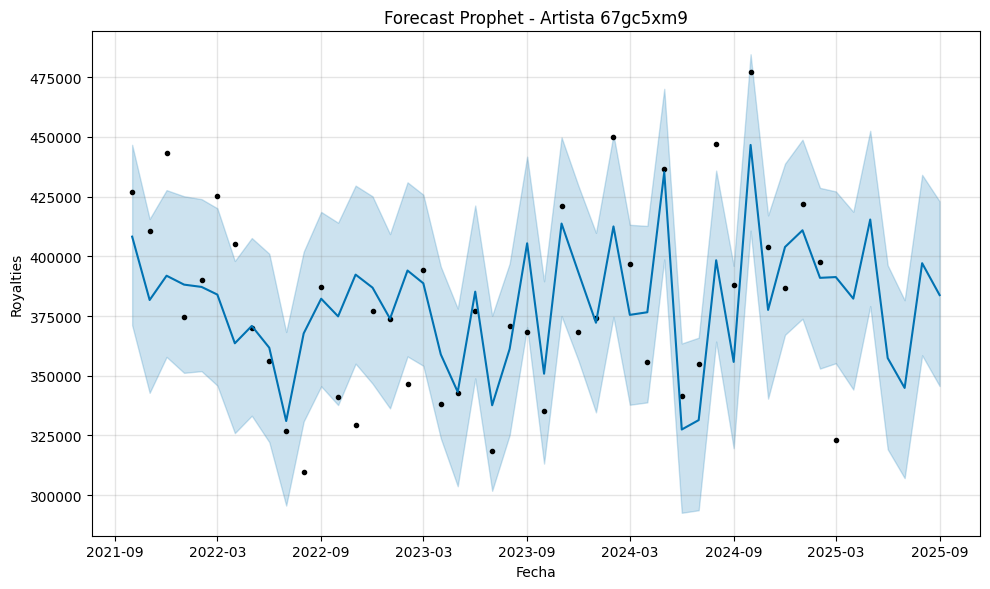

Gráfico de forecast para el artista 6ygz70qs


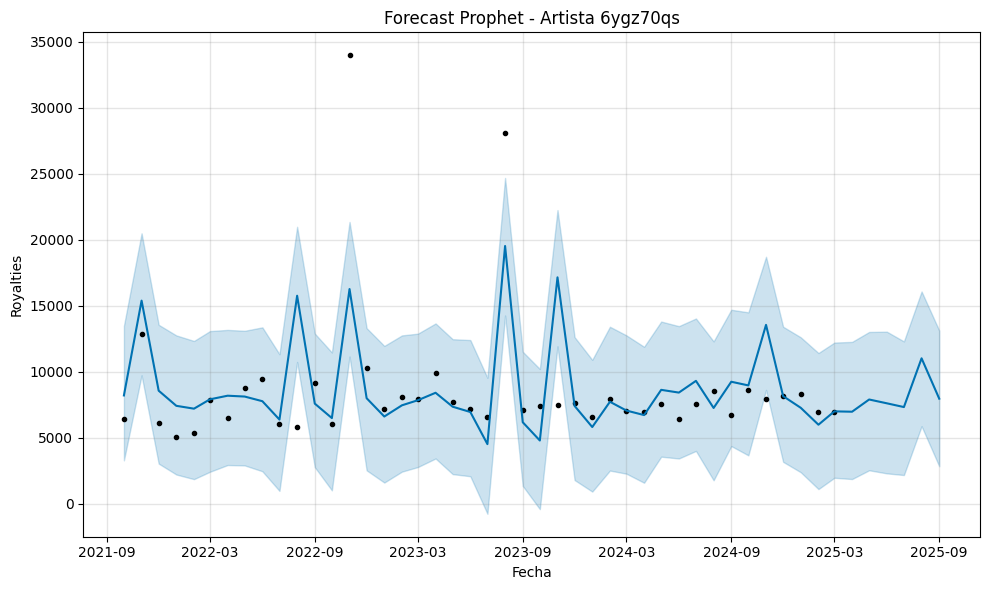

Gráfico de forecast para el artista al0gcvtm


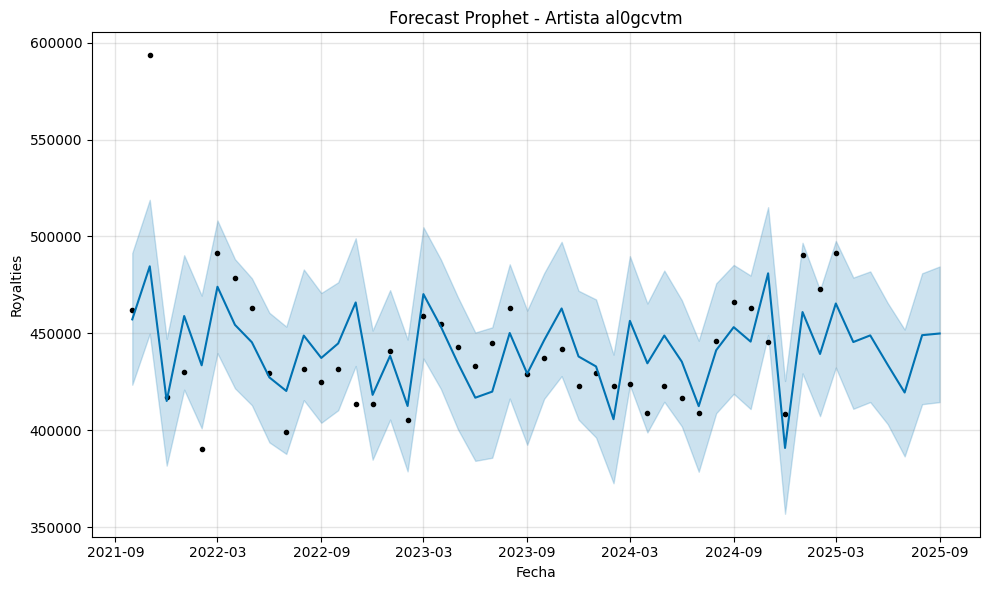

Gráfico de forecast para el artista awrkf92m


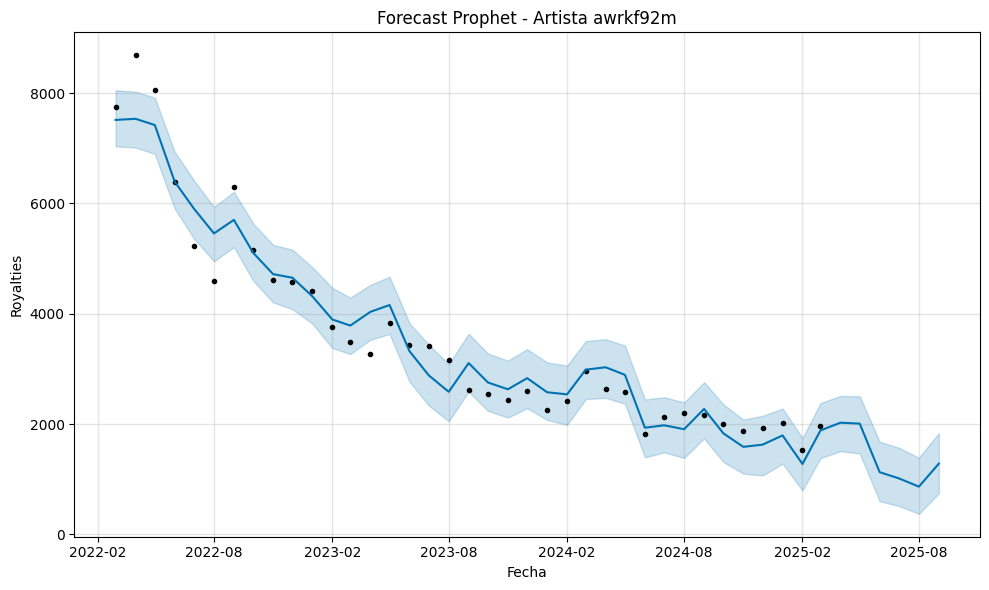

Gráfico de forecast para el artista bpgx7194


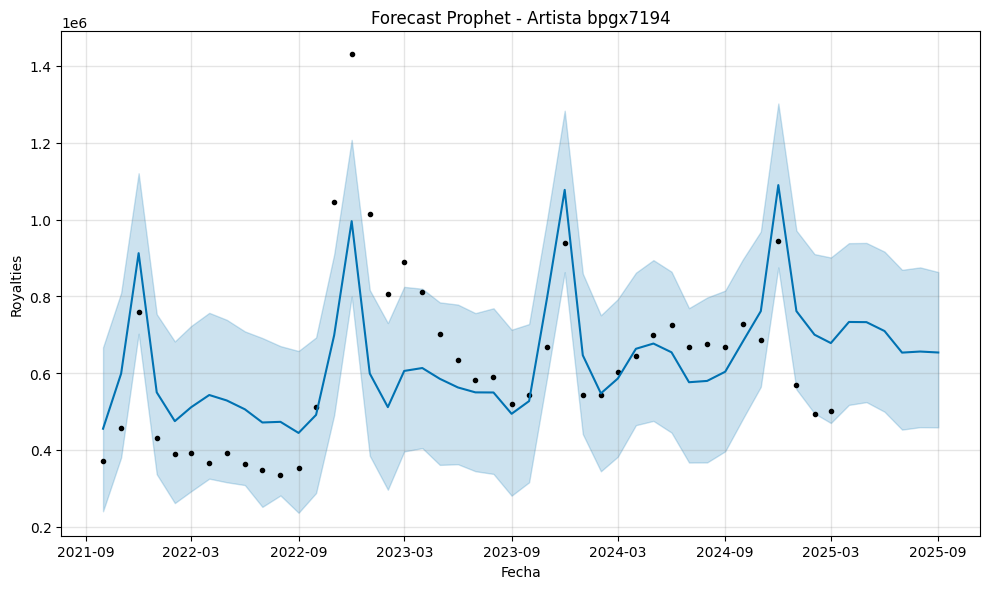

Gráfico de forecast para el artista hfiatnv8


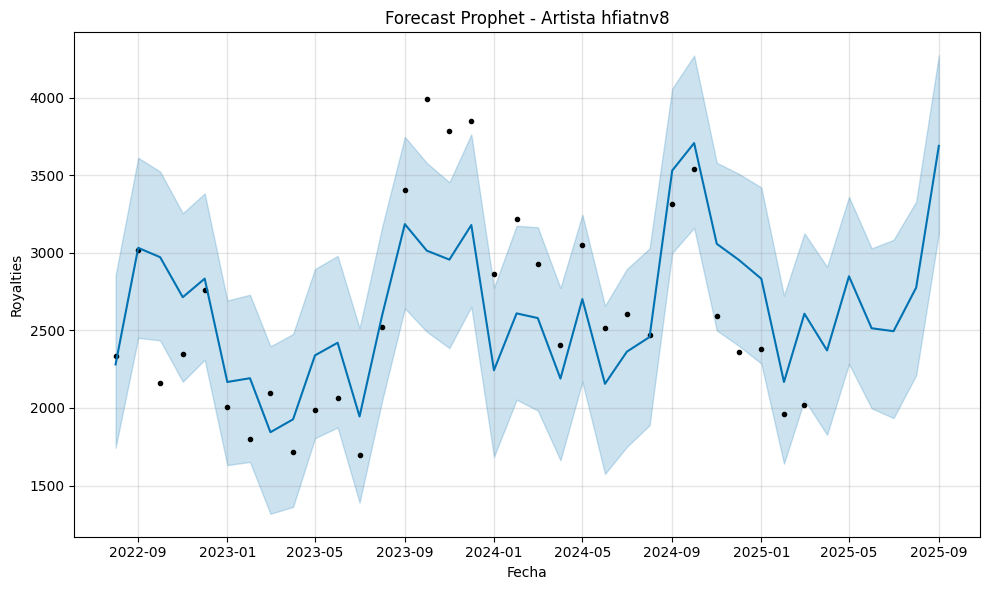

Gráfico de forecast para el artista jla6nu3p


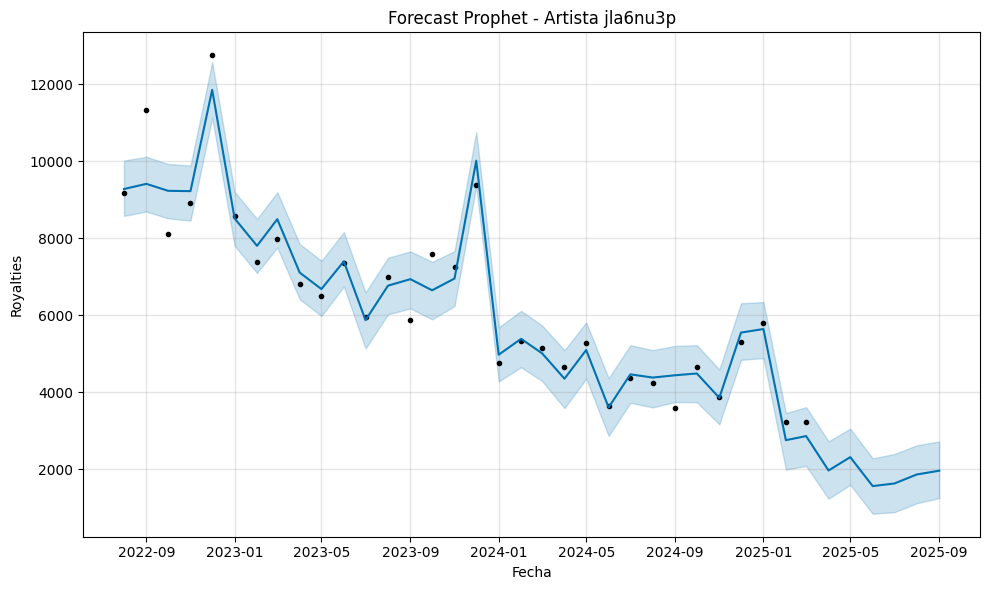

Gráfico de forecast para el artista k74pw1av


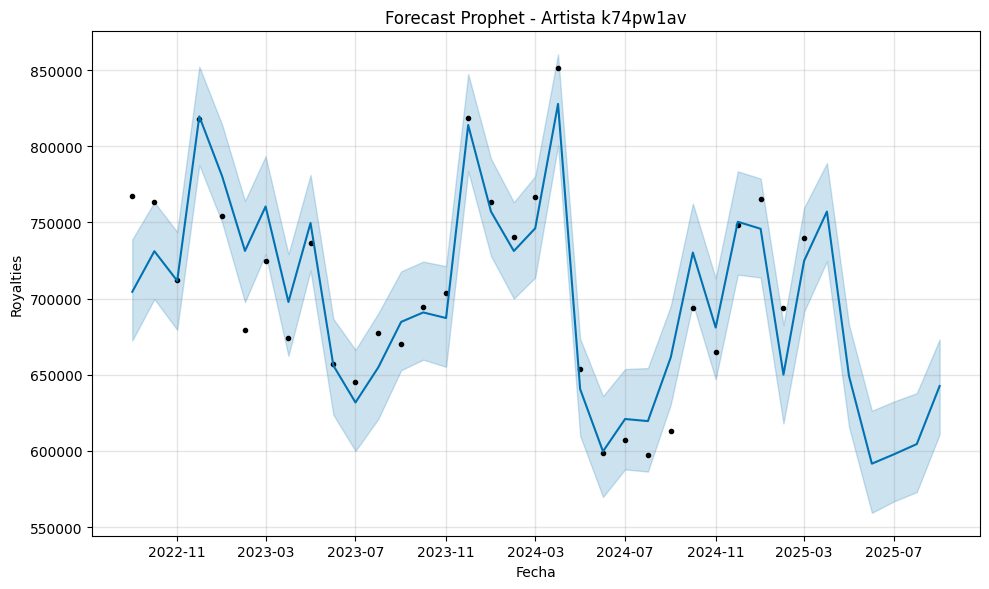

Gráfico de forecast para el artista kcw3uapo


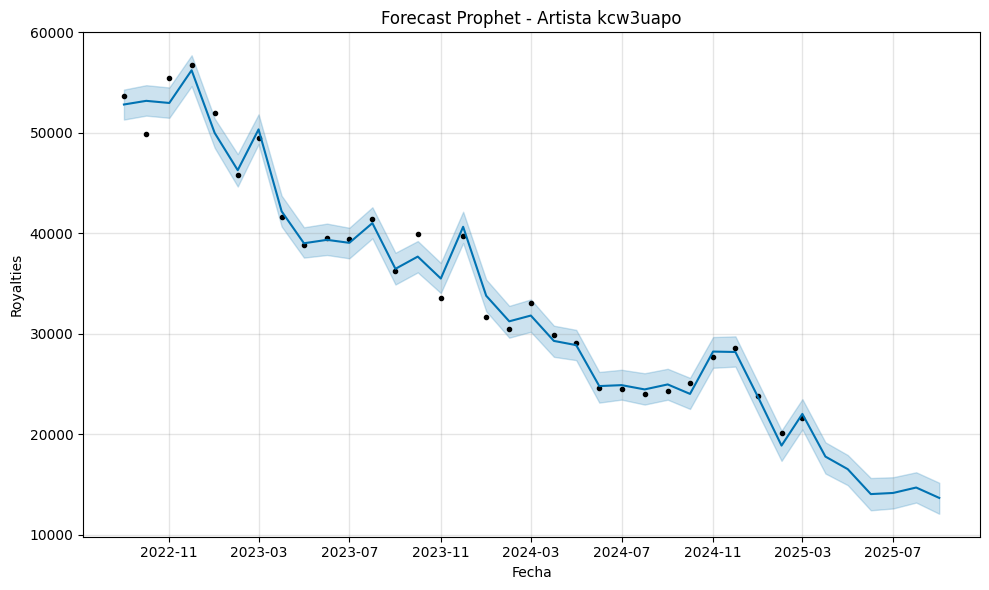

Gráfico de forecast para el artista pymr5w10


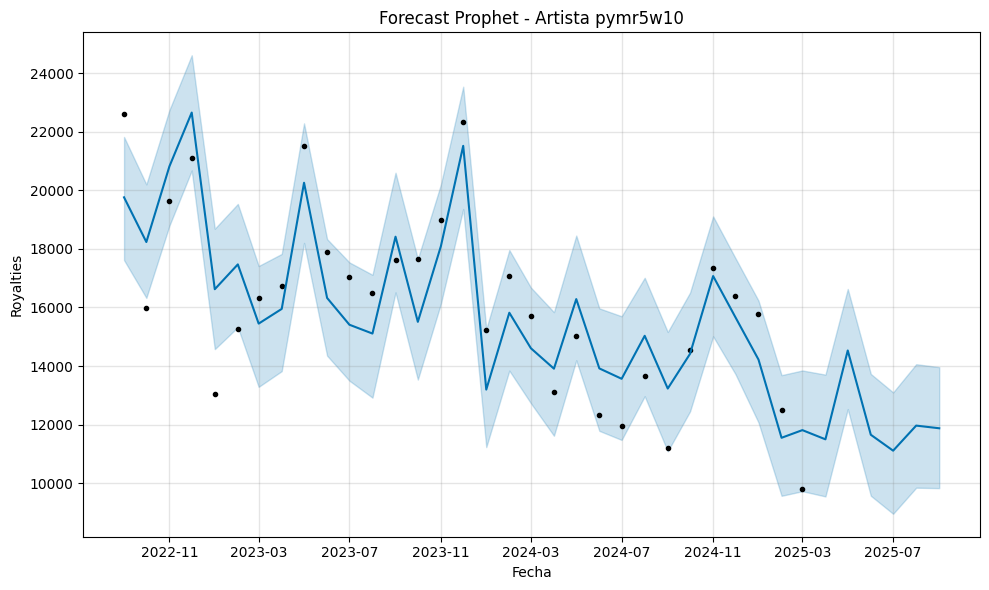

Gráfico de forecast para el artista r976ytqo


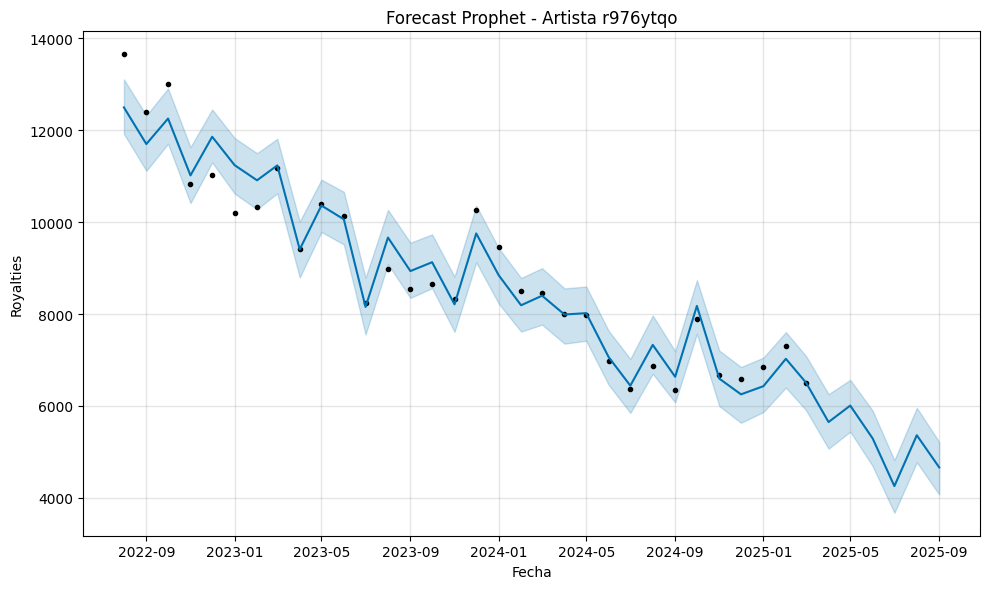

In [7]:
# Mostrar gráficos
for artist_id, figura in lista_figuras:
    print(f"Gráfico de forecast para el artista {artist_id}")
    display(figura)


In [8]:
# Guardar consolidado
df_forecasts_consolidado.to_csv('prophet_forecast_royalties_artistas.csv', index=False)
